Here we will learn how to load and preprocess an image dataset in three different ways.
<li> We will use the high-level Keras preprocessing utilities and layers
<li> Next we write our own input pipeline from scratch using tf.data
<li> We will download the dataset from the large catalog available in TensorFlow Datasets

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
## checking the version
print(tf.__version__)

2.4.0


## Download the Flower Datasets

We have 5 sub directories of photos of flowers

In [4]:
### importing the data file with the tensorflow library

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


In [5]:
## counting the number of images
image_count= len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Each directory contains images of that type of FLower. Printing some flowers

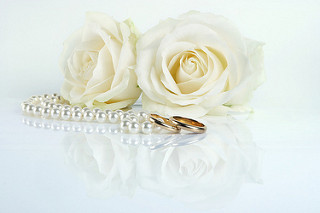

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

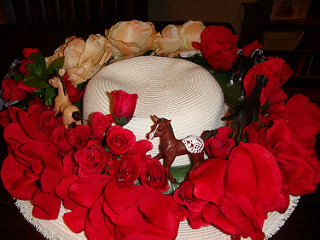

In [8]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

## Load Using Keras and preprocessing

### Create a Dataset

In [10]:
batch_size = 32
img_height = 180
img_width = 180

We will use the 20% of the dataset as a validation and rest for building the model

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=135,
    image_size= (img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=135,
    image_size=(img_height, img_width),
    batch_size= batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


We can find the class names in the class_names attribute on these datsets

In [14]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


The  name of all the classes available in the dataset

# Visualizing the Data

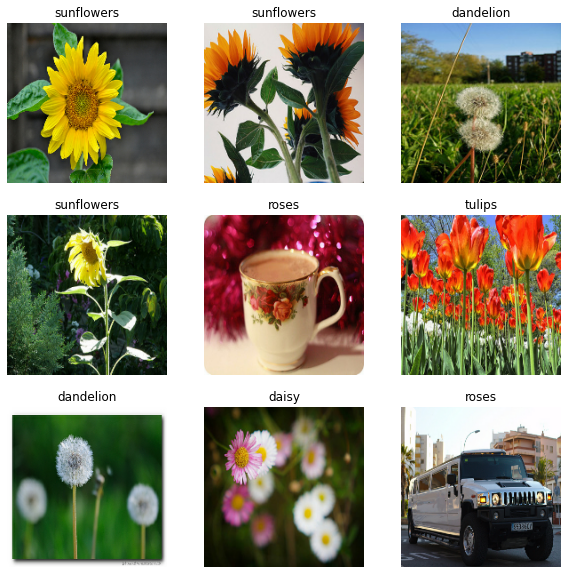

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

We can train the model using these datsets by passing them to model.fit

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image batch is a tensor of the shape (32, 180, 180,3). This is a batch of shape 180x180x3 (it refers to the color channels RGB). The first is the tensor of the shape 32, correspondind labels to the 32 images

We can call numpy() on either of these tensors to convert them to a numoy.ndarray

## Standardize the Data

In [18]:
from tensorflow.keras import layers

In [19]:


normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

There are two ways to use this layer. We can apply it to the datset by calling map

In [20]:
normalized_ds = train_ds.map(lambda x, y :(normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
## pixels are now in the value of [0,1]
print(np.min(first_image), np.max(first_image))

0.0 1.0


We can include the layer inside our model definition to simplify deployment

## Configure the dataset for performance

In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [23]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Train a  Model

In [25]:
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [26]:
model.compile(
    optimizer ='adam',
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [28]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=3
)

Epoch 1/3
92/92 [==============================] - 112s 1s/step - loss: 1.4681 - accuracy: 0.3599 - val_loss: 1.0855 - val_accuracy: 0.5504
Epoch 2/3
92/92 [==============================] - 108s 1s/step - loss: 1.1029 - accuracy: 0.5543 - val_loss: 0.9727 - val_accuracy: 0.6213
Epoch 3/3
92/92 [==============================] - 104s 1s/step - loss: 0.9317 - accuracy: 0.6319 - val_loss: 0.9291 - val_accuracy: 0.6512


## Usinf tf.data for finer controls

In [30]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [31]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/tulips/14487762578_baba13d16a_m.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/2442985637_8748180f69.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/2693136371_dde2570813.jpg'
b'/root/.keras/datasets/flower_photos/daisy/5881907044_92a85a05c8_n.jpg'
b'/root/.keras/datasets/flower_photos/tulips/14651385476_7ccb20e594_m.jpg'


In [32]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))

Split the dataset into train and validation

In [33]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [34]:
## length of each dataset
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


A function that converts a file path to an (img, label) pair

In [39]:
def get_label(file_path):
  ## converts the path 
  parts = tf.strings.split(file_path, os.path.sep)
  one_hot = parts[-2] == class_names
  return tf.argmax(one_hot)

In [41]:
def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  ##resizing the image
  return tf.image.resize(img, [img_height, img_width])

In [42]:
def process_path(file_path):
  label = get_label(file_path)

  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img , label

Use Dataset.map to create a dataset of image, label pairs

In [43]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [44]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


## Configure dataset for performance

In [45]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [46]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

## Visualize the Data

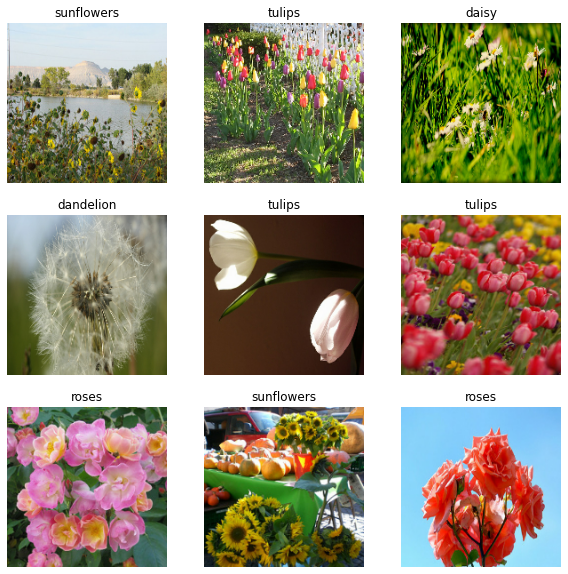

In [49]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

## Continue Training the Model

In [50]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=3
)

Epoch 1/3
92/92 [==============================] - 114s 1s/step - loss: 0.7757 - accuracy: 0.7081 - val_loss: 0.7979 - val_accuracy: 0.7030
Epoch 2/3
92/92 [==============================] - 106s 1s/step - loss: 0.5845 - accuracy: 0.7919 - val_loss: 0.7510 - val_accuracy: 0.7248
Epoch 3/3
92/92 [==============================] - 106s 1s/step - loss: 0.4104 - accuracy: 0.8525 - val_loss: 0.9369 - val_accuracy: 0.6894


## Using Tensorflow Datsets

In [51]:
## downloading the datasets
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [52]:
##flowers datasets has five classes
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


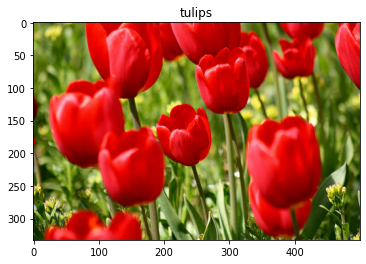

In [53]:
## retrieveing a image from the datasets
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [54]:
## shuffle and configure each dataset
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)